In [1]:
import collections
import requests
import json
import re
import os
import sys
import numpy as np
import matplotlib.pyplot as plt

# Test

In [2]:
with open('../../data/speeches_20.jsonl', 'r', encoding = 'utf8') as fp:
    data = list(fp)
speeches = []
for line in data:
    speeches.append(json.loads(line))

In [3]:
print(speeches[0])

{'text': 'Sehr geehrter Herr Alterspräsident! So muss ich es jetzt sagen, genau; ich muss mich daran gewöhnen. Nicht lange. Nicht lange; da haben Sie schon recht.\xa0– Liebe Kolleginnen und Kollegen! Meine sehr geehrten Damen und Herren! Die Übernahme der Geschäftsordnung ist eine der ersten wichtigen Entscheidungen, die wir heute zu Beginn der Wahlperiode treffen müssen. Die Geschäftsordnung ist Grundlage für unsere gemeinsame Arbeit. Sie hat sich über viele Wahlperioden bewährt und wird uns auch durch die neue Wahlperiode tragen. Es ist gute Tradition, dass wir die Geschäftsordnung am Anfang einer Wahlperiode mit breiter parlamentarischer Mehrheit übernehmen, und das sollten wir auch heute tun. Sie ist nicht in Stein gemeißelt\xa0– das wissen diejenigen, die bereits in der letzten Wahlperiode hier im Bundestag tätig waren\xa0–, sondern die Geschäftsordnung ist immer ein, ich sage mal, lebendiges Dokument, das sich den Gegebenheiten des Parlamentarismus, aber auch den Gegebenheiten de

In [4]:
def groupSpeechesByParty(speeches):
    groupedSpeeches = {}
    for speech in speeches:
        tpo = speech['party']
        if tpo in groupedSpeeches:
            groupedSpeeches[tpo].append(speech)
        else:
            groupedSpeeches[tpo] = [speech]
    return groupedSpeeches

In [5]:
def clean_partyname(speeches):
    for speech in speeches:
        if 'BÜNDNIS\xa090/DIE GRÜNEN'.lower() in speech['party']:
            speech.update({'party': 'BÜNDNIS 90/DIE GRÜNEN'})
clean_partyname(speeches)

In [6]:
groupbyparty = groupSpeechesByParty(speeches)
print(f'alle Reden: {len(speeches)}') # Anzahl aller Reden
#for ele in groupbyparty:
#    print(len(groupbyparty[ele]))
# Überprüfung mit bspw.: len(groupbyparty['SPD'])

alle Reden: 4684


In [7]:
def extract_comments(speeches):
    regex = "{(.*?)}" # hier die genaue Definition der Kommentare vom Parser <<< >
    comments = []
    modified_speeches = []
    for speech in speeches:
        text = speech['text']
        matches = re.findall(regex,text)
        speech['comments'] = matches
        modified_speeches.append(speech)
    return modified_speeches
# Funktionsaufruf: speeches_comments = extract_comments(speeches)
speeches_comments = extract_comments(speeches)
# Funktionsausgabe: print(speeches_comments[0]['comments'])
#                   print(speeches_comments[0]['party'])

In [8]:
# filter: comments per party with contain words and not contain words
def filter_with_complex_non_words(search_terms , non_words , speeches_comments):
    filtered_speeches = []
    for speech in speeches_comments:
        for comment in speech['comments']:
            if all([term in comment for term in search_terms]) and not any([term in comment for term in non_words]):
                filtered_speeches.append(speech)
    return filtered_speeches
# Funktionsaufruf:  specific_and_non_search = filter_with_complex_non_words(['Beifall','CDU'],['Zuruf'],speeches_comments)
# Funktionsausgabe: print(specific_and_non_search[0])                               enthält AND enthält nicht
#                   print(len(specific_and_non_search))
specific_and_non_search = filter_with_complex_non_words([],[],speeches)
print(f'Gesamtsumme aller Kommentare: {len(specific_and_non_search)}')

Gesamtsumme aller Kommentare: 37975


In [9]:
specific_and_non_search = filter_with_complex_non_words(['LINKE'],[],speeches_comments)
print(f'Anzahl Kommentare mit Beteiligung von Linke:        {len(specific_and_non_search)}')
specific_and_non_search = filter_with_complex_non_words(['SPD'],[],speeches_comments)
print(f'Anzahl Kommentare mit Beteiligung von SPD:          {len(specific_and_non_search)}')
specific_and_non_search = filter_with_complex_non_words(['DIE GRÜNEN'],[],speeches_comments)
print(f'Anzahl Kommentare mit Beteiligung von Grünen:       {len(specific_and_non_search)}')
specific_and_non_search = filter_with_complex_non_words(['CDU/CSU'],[],speeches_comments)
print(f'Anzahl Kommentare mit Beteiligung von CDU/CSU:      {len(specific_and_non_search)}')
specific_and_non_search = filter_with_complex_non_words(['FDP'],[],speeches_comments)
print(f'Anzahl Kommentare mit Beteiligung von FDP:          {len(specific_and_non_search)}')
specific_and_non_search = filter_with_complex_non_words(['AfD'],[],speeches_comments)
print(f'Anzahl Kommentare mit Beteiligung von AfD:          {len(specific_and_non_search)}')
specific_and_non_search = filter_with_complex_non_words(['fraktionslos'],[],speeches_comments)
print(f'Anzahl Kommentare mit Beteiligung von Fraktionslos: {len(specific_and_non_search)}')

Anzahl Kommentare mit Beteiligung von Linke:        4935
Anzahl Kommentare mit Beteiligung von SPD:          17575
Anzahl Kommentare mit Beteiligung von Grünen:       17200
Anzahl Kommentare mit Beteiligung von CDU/CSU:      11610
Anzahl Kommentare mit Beteiligung von FDP:          14697
Anzahl Kommentare mit Beteiligung von AfD:          7464
Anzahl Kommentare mit Beteiligung von Fraktionslos: 68


In [10]:
# function: speeches_of_party
def filter_party (party , speeches_comments):
    speeches_of_party = []
    for speech in speeches_comments:
        if speech['party'] == party:
            speeches_of_party.append(speech)
    return speeches_of_party

# function: speeches_of_party_with_keywords
def filter_speeches_of_party(search_terms , non_words , speeches_of_party):
    comments_speaker_of_party = []
    for speech in speeches_of_party:
        for comment in speech['comments']:
            if all([term in comment for term in search_terms]) and not any([term in comment for term in non_words]):
                comments_speaker_of_party.append(comment)
    return comments_speaker_of_party

In [11]:
keywords = ['Beifall','Zuruf','lachen','Widerspruch','Heiterkeit','Unsinn','Gegenruf']
list_party = ['DIE LINKE','SPD','BÜNDNIS 90/DIE GRÜNEN','CDU/CSU','FDP','AfD','fraktionslos']

In [12]:
speeches_of_party = filter_party(list_party[0],speeches_comments)
len(speeches_of_party)

369

In [13]:
speeches_of_party = filter_party(list_party[0],speeches_comments)
speeches_of_party_with_keywords = filter_speeches_of_party( keywords[0] , [] , speeches_of_party)
print(f'Redner von {list_party[0]} erhielt insgesamt {keywords[0]}: {len(speeches_of_party_with_keywords)}')

speeches_of_party = filter_party(list_party[0],speeches_comments)
speeches_of_party_with_keywords = filter_speeches_of_party([keywords[0],'LINKE'] , [] , speeches_of_party)
print(f'Redner von {list_party[0]} erhielt {keywords[0]} von der {list_party[0]}: {len(speeches_of_party_with_keywords)}')

speeches_of_party = filter_party(list_party[0],speeches_comments)
speeches_of_party_with_keywords = filter_speeches_of_party([keywords[0],'SPD'] , [] , speeches_of_party)
print(f'Redner von {list_party[0]} erhielt {keywords[0]} von der {list_party[1]}: {len(speeches_of_party_with_keywords)}')

speeches_of_party = filter_party(list_party[0],speeches_comments)
speeches_of_party_with_keywords = filter_speeches_of_party([keywords[0],'GRÜNE'] , [] , speeches_of_party)
print(f'Redner von {list_party[0]} erhielt {keywords[0]} von der {list_party[2]}: {len(speeches_of_party_with_keywords)}')

speeches_of_party = filter_party(list_party[0],speeches_comments)
speeches_of_party_with_keywords = filter_speeches_of_party([keywords[0],'CDU'] , [] , speeches_of_party)
print(f'Redner von {list_party[0]} erhielt {keywords[0]} von der {list_party[3]}: {len(speeches_of_party_with_keywords)}')

speeches_of_party = filter_party(list_party[0],speeches_comments)
speeches_of_party_with_keywords = filter_speeches_of_party([keywords[0],list_party[4]] , [] , speeches_of_party)
print(f'Redner von {list_party[0]} erhielt {keywords[0]} von der {list_party[4]}: {len(speeches_of_party_with_keywords)}')

speeches_of_party = filter_party(list_party[0],speeches_comments)
speeches_of_party_with_keywords = filter_speeches_of_party([keywords[0],list_party[5]] , [] , speeches_of_party)
print(f'Redner von {list_party[0]} erhielt {keywords[0]} von der {list_party[5]}: {len(speeches_of_party_with_keywords)}')

speeches_of_party = filter_party(list_party[0],speeches_comments)
speeches_of_party_with_keywords = filter_speeches_of_party([keywords[0],'raktionslos'] , [] , speeches_of_party)
print(f'Redner von {list_party[0]} erhielt {keywords[0]} von der {list_party[6]}: {len(speeches_of_party_with_keywords)}')

speeches_of_party = filter_party(list_party[2],speeches_comments)
speeches_of_party_with_keywords = filter_speeches_of_party([keywords[0],'GRÜNE'] , [] , speeches_of_party)
print(f'Redner von {list_party[2]} erhielt {keywords[0]} von der {list_party[2]}: {len(speeches_of_party_with_keywords)}')

#MD: Hier noch mal das angleich vom Printbefehl und des Filters

Redner von DIE LINKE erhielt insgesamt Beifall: 2468
Redner von DIE LINKE erhielt Beifall von der DIE LINKE: 2063
Redner von DIE LINKE erhielt Beifall von der SPD: 540
Redner von DIE LINKE erhielt Beifall von der BÜNDNIS 90/DIE GRÜNEN: 501
Redner von DIE LINKE erhielt Beifall von der CDU/CSU: 170
Redner von DIE LINKE erhielt Beifall von der FDP: 382
Redner von DIE LINKE erhielt Beifall von der AfD: 153
Redner von DIE LINKE erhielt Beifall von der fraktionslos: 0
Redner von BÜNDNIS 90/DIE GRÜNEN erhielt Beifall von der BÜNDNIS 90/DIE GRÜNEN: 4186


In [14]:
speeches_of_party = filter_party(list_party[2],speeches)
print(list_party[0])
speeches_of_party_with_keywords = filter_speeches_of_party([keywords[0],list_party[0]] , [] , speeches_of_party)
print(len(speeches_of_party_with_keywords))
print(f'Redner von {list_party[0]} erhielt {keywords[0]} von der {list_party[0]}: {len(speeches_of_party_with_keywords)}')

DIE LINKE
158
Redner von DIE LINKE erhielt Beifall von der DIE LINKE: 158


In [15]:
# Alle Kommentare mit Beifall
#speeches_of_party = filter_party(list_party[0],speeches_comments)
speeches_of_party_with_keywords = filter_speeches_of_party([keywords[0]] ,[], speeches_comments) # Achtung: speeches_comments statt speeches_of_party  
len(speeches_of_party_with_keywords)

26917

In [16]:
comments_to = {'BÜNDNIS 90/DIE GRÜNEN' : [], 
               'CDU/CSU'               : [],
               'Fraktionslos'          : [],
               'AfD'                   : [],
               'SPD'                   : [],
               'FDP'                   : [],
               'DIE LINKE'             : []}
comments_to

{'BÜNDNIS 90/DIE GRÜNEN': [],
 'CDU/CSU': [],
 'Fraktionslos': [],
 'AfD': [],
 'SPD': [],
 'FDP': [],
 'DIE LINKE': []}

In [17]:
party_names = []
for speech in speeches:
    if speech['party'] in party_names:
        pass
    else:
        party_names.append(speech['party'])  
party_names

['SPD',
 'CDU/CSU',
 'BÜNDNIS 90/DIE GRÜNEN',
 'FDP',
 'AfD',
 'DIE LINKE',
 'unknown',
 'Fraktionslos']

In [18]:
comments_to = {}
for party in party_names:
    comments_to.update({ party : [] })
for speech in speeches:
    if len(speech['comments']) > 0:
        for comment in speech['comments']:
            #if '–' in comment:
            #   print(comment)
            for split_comment in comment.split(' – '):
                comments_to[speech['party']].append(split_comment)
print(split_comment)

(Beifall bei der SPD, dem BÜNDNIS 90/DIE GRÜNEN und der FDP)


In [19]:
nParties = len(party_names)
relations_beifall = np.zeros((nParties,nParties),dtype=np.uint32)
party_search_string = ['LINKE','SPD','GRÜNE','CDU','FDP','AfD','fraktionslos']
for px,xparty in enumerate(comments_to): # xparty ist der Partyname aus dem dict
    for comment in comments_to[xparty]: #Zugriff auf das Array der ausgewalten Partei
        for py,yparty in enumerate(party_search_string):
            if yparty in comment and 'Beifall' in comment:
                relations_beifall[px,py] = relations_beifall[px,py] + 1
#plt.imshow(relations_beifall)
#plt.colorbar()
#plt.show()

In [20]:
def print_relations_beifall(relations,parties):
    for x,xparty in enumerate(parties):
        for y,yparty in enumerate(parties):
            print(f'Beifall für Redner {xparty} von Partei {yparty}: {relations[x,y]}')
            
print_relations_beifall(relations_beifall,party_search_string)
print(relations_beifall)

Beifall für Redner LINKE von Partei LINKE: 667
Beifall für Redner LINKE von Partei SPD: 5998
Beifall für Redner LINKE von Partei GRÜNE: 5307
Beifall für Redner LINKE von Partei CDU: 1232
Beifall für Redner LINKE von Partei FDP: 4382
Beifall für Redner LINKE von Partei AfD: 596
Beifall für Redner LINKE von Partei fraktionslos: 6
Beifall für Redner SPD von Partei LINKE: 266
Beifall für Redner SPD von Partei SPD: 1624
Beifall für Redner SPD von Partei GRÜNE: 1576
Beifall für Redner SPD von Partei CDU: 4983
Beifall für Redner SPD von Partei FDP: 1367
Beifall für Redner SPD von Partei AfD: 629
Beifall für Redner SPD von Partei fraktionslos: 1
Beifall für Redner GRÜNE von Partei LINKE: 527
Beifall für Redner GRÜNE von Partei SPD: 3626
Beifall für Redner GRÜNE von Partei GRÜNE: 4186
Beifall für Redner GRÜNE von Partei CDU: 815
Beifall für Redner GRÜNE von Partei FDP: 3221
Beifall für Redner GRÜNE von Partei AfD: 353
Beifall für Redner GRÜNE von Partei fraktionslos: 2
Beifall für Redner CDU vo

In [21]:
print(f'Beifall für Redner {party_search_string[0]} von Partei {party_search_string[0]}: {relations_beifall[0,0]}')
print(f'Beifall für Redner {party_search_string[0]} von Partei {party_search_string[1]}: {relations_beifall[0,1]}')
print(f'Beifall für Redner {party_search_string[0]} von Partei {party_search_string[2]}: {relations_beifall[0,2]}')
print(f'Beifall für Redner {party_search_string[0]} von Partei {party_search_string[3]}: {relations_beifall[0,3]}')
print(f'Beifall für Redner {party_search_string[0]} von Partei {party_search_string[4]}: {relations_beifall[0,4]}')
print(f'Beifall für Redner {party_search_string[0]} von Partei {party_search_string[5]}: {relations_beifall[0,5]}')
print(f'Beifall für Redner {party_search_string[0]} von Partei {party_search_string[6]}: {relations_beifall[0,6]}')

Beifall für Redner LINKE von Partei LINKE: 667
Beifall für Redner LINKE von Partei SPD: 5998
Beifall für Redner LINKE von Partei GRÜNE: 5307
Beifall für Redner LINKE von Partei CDU: 1232
Beifall für Redner LINKE von Partei FDP: 4382
Beifall für Redner LINKE von Partei AfD: 596
Beifall für Redner LINKE von Partei fraktionslos: 6


In [22]:
# Idee zur Programmierung: gehe beide Listen durch und iteriere
nParties = len(list_party)
relations_Beifall = np.zeros((nParties,nParties))
party_search_string = ['GRÜNEN','CDU/CSU','raktionslos','AfD','SPD','FDP','LINKE']
for px,x_party in enumerate(list_party): # for px,party in enumerate(list_party) = weist einer Liste eine lfd. Nummer zu 
    for py,y_party in enumerate(list_party):
        speeches_of_party = filter_party(list_party[px],speeches_comments)
        speeches_of_party_with_keywords = filter_speeches_of_party([keywords[0],list_party[py]],keywords[1:5],speeches_of_party)
        relations_Beifall[px,py] = len(speeches_of_party_with_keywords)
print(relations_Beifall[4,1])

2307.0


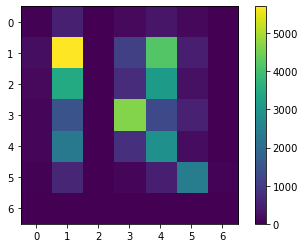

In [23]:
plt.imshow(relations_Beifall)
plt.colorbar()
plt.show()

In [24]:
speeches_of_party = filter_party(list_party[4],speeches_comments)
speeches_of_party_with_keywords = filter_speeches_of_party([keywords[0],list_party[1]] , keywords[1:5] , speeches_of_party)
print(f'Redner von {list_party[4]} erhielt {keywords[0]} von der {list_party[1]}: {len(speeches_of_party_with_keywords)}')

speeches_of_party = filter_party(list_party[1],speeches_comments)
speeches_of_party_with_keywords = filter_speeches_of_party([keywords[0],list_party[4]] , keywords[1:5] , speeches_of_party)
print(f'Redner von {list_party[1]} erhielt {keywords[0]} von der {list_party[4]}: {len(speeches_of_party_with_keywords)}')

speeches_of_party = filter_party(list_party[0],speeches_comments)
speeches_of_party_with_keywords = filter_speeches_of_party([keywords[0],list_party[0]] , keywords[1:5] , speeches_of_party)
print(f'Redner von {list_party[0]} erhielt {keywords[0]} von der {list_party[0]}: {len(speeches_of_party_with_keywords)}')

Redner von FDP erhielt Beifall von der SPD: 2307
Redner von SPD erhielt Beifall von der FDP: 4180
Redner von DIE LINKE erhielt Beifall von der DIE LINKE: 42


TypeError: Invalid shape (2,) for image data

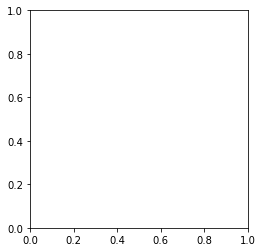

In [25]:
fig, ax = plt.subplots()

intersection_matrix = relations_Beifall[px,py],size=(len(list_party), len(list_party))


#np.random.randint(0, 10, size=(len(list_party), len(list_party)))

ax.matshow(intersection_matrix, cmap=plt.cm.Blues)

for px in range(7):
    for py in range(7):
        c = intersection_matrix[px,py]
        ax.text(px, py, str(c), va='center', ha='center')